In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import torch
import numpy as np
from torchvision import models, transforms
from torchvision.ops import nms
from PIL import Image, ImageDraw
import imagehash
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

MODEL_PATH = "/kaggle/input/best-model/best_model.pth"

DATASET_ROOT = "/kaggle/input/pcb-defect-dataset/PCB_DATASET"
GOLDEN_DIR = os.path.join(DATASET_ROOT, "PCB_USED")
TEST_DIR   = os.path.join(DATASET_ROOT, "images")


Using device: cpu


In [3]:
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

assert "model_state_dict" in checkpoint
assert "class_names" in checkpoint

class_names = checkpoint["class_names"]
num_classes = len(class_names)

print("Model trained with classes (locked order):")
for i, c in enumerate(class_names):
    print(f" {i} → {c}")

model = models.efficientnet_b0(weights=None)
model.classifier[1] = torch.nn.Linear(
    model.classifier[1].in_features,
    num_classes
)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(DEVICE)
model.eval()


Model trained with classes (locked order):
 0 → Missing_hole
 1 → Mouse_bite
 2 → Open_circuit
 3 → Short
 4 → Spur
 5 → Spurious_copper


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [4]:
IMG_SIZE = 128
WINDOW = 128
STRIDE = 32
SSIM_THRESH = 0.95
CONF_THRESH = 0.80

tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [5]:
def load_golden_db(dir_path):
    db = []
    for f in os.listdir(dir_path):
        path = os.path.join(dir_path, f)
        try:
            img = Image.open(path).convert("RGB")
            db.append({
                "img": img,
                "hash": imagehash.phash(img)
            })
        except:
            pass
    return db

golden_db = load_golden_db(GOLDEN_DIR)
print("Golden PCB count:", len(golden_db))


Golden PCB count: 10


In [6]:
def find_best_golden(test_img, golden_db):
    h = imagehash.phash(test_img)
    return min(golden_db, key=lambda x: h - x["hash"])["img"]


In [7]:
def detect_defects(test_img, golden_img):
    detections = []
    w, h = test_img.size

    for y in range(0, h - WINDOW + 1, STRIDE):
        for x in range(0, w - WINDOW + 1, STRIDE):
            tp = test_img.crop((x, y, x+WINDOW, y+WINDOW))
            gp = golden_img.crop((x, y, x+WINDOW, y+WINDOW))

            s = ssim(
                np.array(gp.convert("L")),
                np.array(tp.convert("L"))
            )

            if s < SSIM_THRESH:
                inp = tf(tp).unsqueeze(0).to(DEVICE)
                with torch.no_grad():
                    prob = torch.softmax(model(inp), dim=1)
                    conf, _ = torch.max(prob, 1)

                if conf.item() > CONF_THRESH:
                    detections.append({
                        "box": [x, y, x+WINDOW, y+WINDOW],
                        "conf": conf.item()
                    })

    if not detections:
        return []

    boxes = torch.tensor([d["box"] for d in detections], dtype=torch.float32)
    scores = torch.tensor([d["conf"] for d in detections])
    keep = nms(boxes, scores, 0.2)

    return [detections[i] for i in keep]


In [8]:
def draw_results(img, detections):
    img = img.copy()
    draw = ImageDraw.Draw(img)

    for d in detections:
        draw.rectangle(d["box"], outline="red", width=3)
        draw.text(
            (d["box"][0], d["box"][1]-12),
            f"Defect ({d['conf']:.2f})",
            fill="red"
        )

    return img


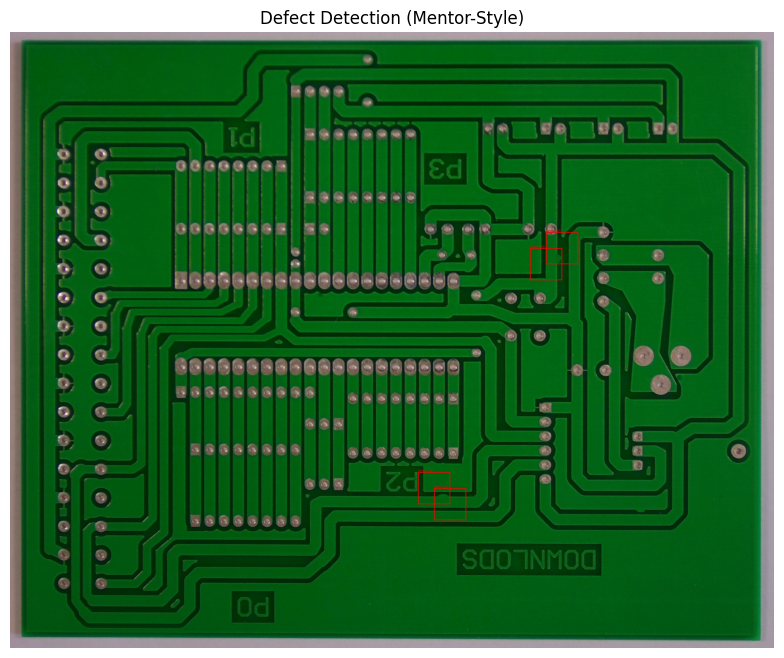

In [9]:
test_img_path = os.path.join(
    TEST_DIR, "Spur", "04_spur_02.jpg"
)

test_img = Image.open(test_img_path).convert("RGB")
golden_img = find_best_golden(test_img, golden_db)

detections = detect_defects(test_img, golden_img)
result = draw_results(test_img, detections)

plt.figure(figsize=(12,8))
plt.imshow(result)
plt.title("Defect Detection (Mentor-Style)")
plt.axis("off")
plt.show()


In [ ]:
OUTPUT_DIR = "/kaggle/working/batch_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for cls in os.listdir(TEST_DIR):
    cls_dir = os.path.join(TEST_DIR, cls)
    if not os.path.isdir(cls_dir):
        continue

    for fname in os.listdir(cls_dir):
        if not fname.lower().endswith(".jpg"):
            continue

        path = os.path.join(cls_dir, fname)
        img = Image.open(path).convert("RGB")
        golden = find_best_golden(img, golden_db)

        dets = detect_defects(img, golden)
        out = draw_results(img, dets)

        out.save(os.path.join(OUTPUT_DIR, fname))

print("Batch inference completed.")


In [14]:
import os
import zipfile

OUTPUT_DIR = "/kaggle/working/batch_outputs"
ZIP_PATH = "/kaggle/working/defect_detection_outputs.zip"

with zipfile.ZipFile(ZIP_PATH, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(OUTPUT_DIR):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, OUTPUT_DIR)
            zipf.write(file_path, arcname)

print("ZIP file created at:", ZIP_PATH)


ZIP file created at: /kaggle/working/defect_detection_outputs.zip


In [ ]:
import os
import zipfile

OUTPUT_DIR = "/kaggle/working/batch_outputs"
ZIP_PATH = "/kaggle/working/defect_detection_outputs.zip"

# Safety check
assert os.path.exists(OUTPUT_DIR), "batch_outputs folder does not exist!"

with zipfile.ZipFile(ZIP_PATH, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(OUTPUT_DIR):
        for file in files:
            full_path = os.path.join(root, file)
            zipf.write(
                full_path,
                arcname=os.path.relpath(full_path, OUTPUT_DIR)
            )

print("✅ ZIP created:", ZIP_PATH)
